In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_log_error, make_scorer, mean_squared_log_error
from sklearn.model_selection import cross_val_score, cross_val_predict
import lightgbm as lgb
import optuna
from sklearn import ensemble
from sklearn.ensemble import StackingRegressor
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from xgboost import XGBRegressor


In [35]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

In [36]:
train_df.head()

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,4,female,38,166.0,61.0,25.0,102.0,40.6,146.0


In [37]:
train_df.isna().sum() 

id            0
Sex           0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
Calories      0
dtype: int64

In [38]:
# binary encoding

train_df['Sex'] = train_df['Sex'].apply(lambda x: 1 if x == 'male' else 0)
test_df['Sex'] = test_df['Sex'].apply(lambda x: 1 if x == 'male' else 0)

In [39]:
def new_features(df):
    
    # Body mass index
    df['BMR'] = np.where(
        df['Sex'] == 1,
        (66.1 + 13.8 * df['Weight'] + 5 * df['Height'] - 6.8 * df['Age'])/100,
        (655 + 9.5 * df['Weight'] + 1.9 * df['Height']/100- 4.7 * df['Age'])/100
    )
    
    # Training intensity
    df['HR_per_kg'] = df['Heart_Rate']/df['Weight']
    df['Temp_per_kg'] = df['Body_Temp']/df['Weight']
    df['Pulse'] = df['Heart_Rate']*0.8
    df['lower_limit_pulse'] = (220 - df['Age'])*0.6
    df['upper_limit_ pulse'] = (220 - df['Age'])*0.8
    df['Duration_HR'] = df['Heart_Rate']*df['Duration']
    df['log_Duration_HR'] = np.log(df['Heart_Rate']*df['Duration'])
    df['Duration_Age'] = df['Duration']*df['Age']
    df['log_Duration_Age'] = np.log(df['Duration']*df['Age'])
    df['Age_HR'] = df['Age']*df['Heart_Rate']
    df['log_Age_HR'] = np.log(df['Age']*df['Heart_Rate'])
    df['Duration/Weight'] = df['Weight']*df['Duration']
    df['log_Duration/Weight'] = np.log(df['Weight']*df['Duration'])
    
    # Age Groups
    df['Age_Group'] = df['Age'].apply(lambda x: 0 if x <= 35 else 1 if x <= 55 else 2)
    
    
    
    return df

In [40]:
# Launch func

train_df = new_features(train_df)
test_df = new_features(test_df)

In [41]:
# df split

X_train = train_df.drop(['Calories', 'id'], axis=1)
y_train = train_df['Calories']

X_test = test_df.drop(['id'], axis=1)

In [45]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 16),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),  # минимальный прирост для деления
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),  # L1-регуляризация
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),  # L2-регуляризация
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),  # минимальное количество веса в узле
        'objective': 'reg:squaredlogerror',  # специально для RMSLE
        'random_state': 42,
        'verbosity': 0,
        'n_jobs': -1
    }

    model = XGBRegressor(**params)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_train)
    y_pred = np.maximum(0, y_pred)  # устраняем отрицательные значения

    try:
        rmsle = root_mean_squared_log_error(y_train, y_pred)
    except ValueError:
        return float('inf')

    return rmsle

In [46]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50, timeout=600)  # 50 попыток или 10 минут

print("Лучшие параметры:", study.best_params)
print("Лучшее значение RMSLE:", study.best_value)

[I 2025-05-26 00:52:21,898] A new study created in memory with name: no-name-7b4034f2-07f6-4abe-96a1-912c21f3c435
[I 2025-05-26 00:52:26,417] Trial 0 finished with value: 0.1086381576690694 and parameters: {'n_estimators': 149, 'max_depth': 6, 'learning_rate': 0.0799254065061866, 'subsample': 0.5611940113361904, 'colsample_bytree': 0.7241383957499357, 'gamma': 4.517452286374891, 'reg_alpha': 2.859943328638158, 'reg_lambda': 3.059685265696362, 'min_child_weight': 7}. Best is trial 0 with value: 0.1086381576690694.
[I 2025-05-26 00:52:33,276] Trial 1 finished with value: 2.271968484598473 and parameters: {'n_estimators': 279, 'max_depth': 16, 'learning_rate': 0.24800790711541704, 'subsample': 0.823187336098596, 'colsample_bytree': 0.8675065124905266, 'gamma': 0.9945442244760716, 'reg_alpha': 0.20330281664859562, 'reg_lambda': 2.8818586023036947, 'min_child_weight': 7}. Best is trial 0 with value: 0.1086381576690694.
[I 2025-05-26 00:52:37,094] Trial 2 finished with value: 0.1252617941770

Лучшие параметры: {'n_estimators': 453, 'max_depth': 16, 'learning_rate': 0.03836061781229073, 'subsample': 0.9464266118634337, 'colsample_bytree': 0.9438064950301522, 'gamma': 4.339404833944376, 'reg_alpha': 1.0324115848941917, 'reg_lambda': 2.7831098098578195, 'min_child_weight': 1}
Лучшее значение RMSLE: 0.0725814635758483


In [51]:
xgb_params = {'n_estimators': 453,
 'max_depth': 16,
 'learning_rate': 0.03836061781229073,
 'subsample': 0.9464266118634337,
 'colsample_bytree': 0.9438064950301522,
 'gamma': 4.339404833944376,
 'reg_alpha': 1.0324115848941917,
 'reg_lambda': 2.7831098098578195,
 'min_child_weight': 1
 }

In [ ]:
xgb_model = XGBRegressor(**xgb_params)
xgb_model.fit(X_train, y_train)

# Prediction
y_pred_xgb = cross_val_predict(xgb_model, X_train, y_train, cv=5)

print(f'RMSLE_train: {round(root_mean_squared_log_error(y_pred_xgb , y_train),5)}')

RMSLE_train: 0.06091


             feature  importance
14   log_Duration_HR    0.551270
13       Duration_HR    0.412768
0                Sex    0.015281
17            Age_HR    0.008164
4           Duration    0.004495
18        log_Age_HR    0.003188
5         Heart_Rate    0.001398
10             Pulse    0.001307
7                BMR    0.000462
15      Duration_Age    0.000382
3             Weight    0.000356
9        Temp_per_kg    0.000188
19   Duration/Weight    0.000174
16  log_Duration_Age    0.000103
8          HR_per_kg    0.000101


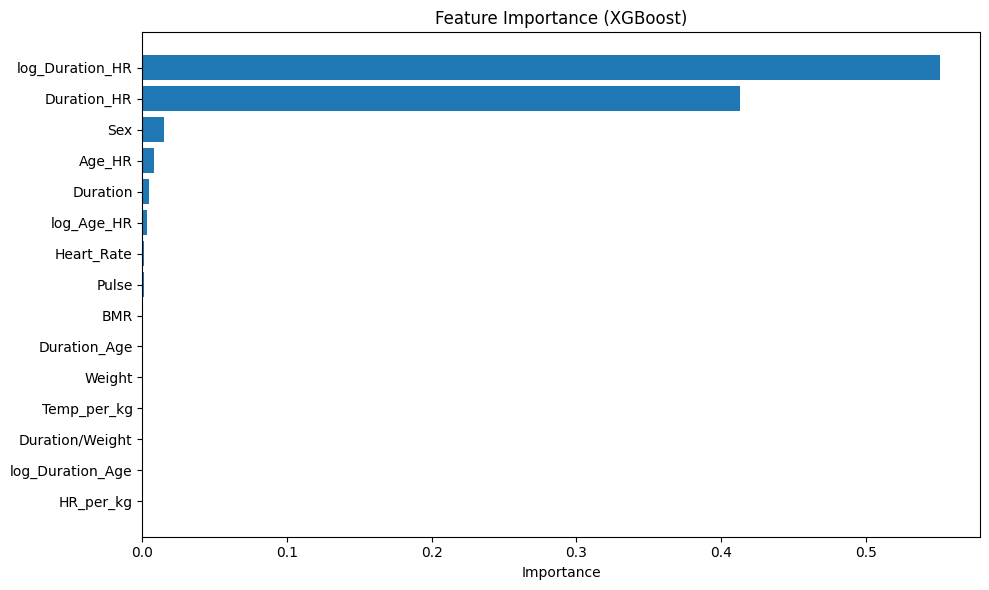

In [53]:
# Получаем важности
importance_df = pd.DataFrame({
    "feature": X_train.columns,
    "importance": xgb_model.feature_importances_
}).sort_values(by="importance", ascending=False)

# Печатаем топ-N
print(importance_df.head(15))

# Визуализация
plt.figure(figsize=(10, 6))
plt.barh(importance_df["feature"].head(15)[::-1], importance_df["importance"].head(15)[::-1])
plt.title("Feature Importance (XGBoost)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

In [55]:
top_features = list(importance_df['feature'].values)[:20]

In [56]:
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

In [57]:
xgb_model = XGBRegressor(**xgb_params)
xgb_model.fit(X_train, y_train)

# Prediction
y_pred_xgb = cross_val_predict(xgb_model, X_train_top, y_train, cv=5)

print(f'RMSLE_train: {round(root_mean_squared_log_error(y_pred_xgb , y_train),5)}')

RMSLE_train: 0.06096


In [69]:
tree_params = {'n_estimators': 174, 'max_depth': 17, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2','n_jobs': -1}

In [70]:
model_tree = ensemble.RandomForestRegressor(**tree_params)

model_tree.fit(X_train_top, y_train)

# Prediction
y_pred_tree= cross_val_predict(model_tree, X_train_top, y_train, cv=5)

# Prediction
print(f'RMSLE_train: {round(root_mean_squared_log_error(y_pred_tree, y_train),5)}')

RMSLE_train: 0.06109


In [71]:
# Метрика RMSLE
def rmsle(y_true, y_pred):
    return mean_squared_log_error(y_true, y_pred) ** 0.5

rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

# --------------------------
# Базовые модели
base_models = [
    ('rf', ensemble.RandomForestRegressor(**tree_params)),
    ('lgbm', XGBRegressor(**xgb_params))
]

# Мета-модель
meta_model = linear_model.LinearRegression()

# Стекинг-модель
stacked_model = StackingRegressor(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5,
    n_jobs=-1
)

# --------------------------
# Кросс-валидация на тренировочной выборке
scores = cross_val_score(
    stacked_model, 
    X_train_top, 
    y_train, 
    cv=5, 
    scoring=rmsle_scorer,
    n_jobs=-1
)

print(f'RMSLE_CV: {round(-scores.mean(), 5)} ± {round(scores.std(), 5)}')


RMSLE_CV: 0.06046 ± 0.00091
